In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

import pathlib
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
data_dir = 'datasets'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
image_count

100

In [3]:
raw_durian_images_dict = {
    'ripe' : list(data_dir.glob('ripe/*')),
    'unripe' : list(data_dir.glob('unripe/*')),
} 
raw_durian_labels_dict = {
    'ripe' : 0,
    'unripe' : 1
}

In [4]:
X, y = [], []

output_folder = "resized_images"

for durian_ripeness, images in raw_durian_images_dict.items():
    for index, image in enumerate(images):
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(200,200))
        X.append(resized_img)
        y.append(raw_durian_labels_dict[durian_ripeness])
        
        # Uncomment if you want to check all the resized images
        # output_name = f"{durian_ripeness}_{index}.jpg"
        # output_path = os.path.join(output_folder, output_name)
        # cv2.imwrite(output_path, resized_img)

In [5]:
X = np.array(X)
y = np.array(y)

In [23]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.6)
X_train_scaled = X_train /255
X_test_scaled = X_test /255

In [24]:
convDim = 5
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (convDim,convDim), activation='relu', input_shape=(200,200,3)),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Conv2D(128, (convDim,convDim), activation='relu'),
    tf.keras.layers.MaxPool2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),  # Add dropout layer
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# model.summary()

In [25]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training when the loss falls below 0.4

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check the loss
    if(logs.get('accuracy') == 1.0):

      # Stop if threshold is met
      print("\Accuracy is reached than 1.0 so cancelling training!")
      self.model.stop_training = True

# Instantiate class
callbacks = myCallback()

In [26]:
EPOCH = 25
BATCH_SIZE = 32
model_fit = model.fit(X_train_scaled, y_train, epochs=EPOCH, validation_data=(X_test_scaled, y_test), batch_size=BATCH_SIZE, 
                      # callbacks=callbacks
                      ) 

Epoch 1/25
2/2 [==============================] - 3s 1s/step - loss: 2.1617 - accuracy: 0.5500 - val_loss: 10.4040 - val_accuracy: 0.5250
Epoch 2/25
2/2 [==============================] - 2s 1s/step - loss: 7.0258 - accuracy: 0.4833 - val_loss: 0.8654 - val_accuracy: 0.4750
Epoch 3/25
2/2 [==============================] - 2s 1s/step - loss: 0.7571 - accuracy: 0.5000 - val_loss: 0.6700 - val_accuracy: 0.5250
Epoch 4/25
2/2 [==============================] - 2s 1s/step - loss: 0.6607 - accuracy: 0.6000 - val_loss: 0.5809 - val_accuracy: 0.9750
Epoch 5/25
2/2 [==============================] - 2s 1s/step - loss: 0.7350 - accuracy: 0.6833 - val_loss: 1.0393 - val_accuracy: 0.5250
Epoch 6/25
2/2 [==============================] - 2s 1s/step - loss: 0.9827 - accuracy: 0.4833 - val_loss: 0.6439 - val_accuracy: 0.5250
Epoch 7/25
2/2 [==============================] - 2s 1s/step - loss: 0.6286 - accuracy: 0.5167 - val_loss: 0.6293 - val_accuracy: 0.9750
Epoch 8/25
2/2 [========================

In [27]:
test_loss , test_accuracy = model.evaluate(X_test_scaled,y_test)
print(f'Model Accuracy: {test_accuracy}')

2/2 [==============================] - 0s 52ms/step - loss: 0.1987 - accuracy: 0.9750
Model Accuracy: 0.9750000238418579


In [28]:
predictions = model.predict(X_test_scaled)
predictions = np.round(predictions,2)
predictions

2/2 [==============================] - 0s 55ms/step


array([[1.  ],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.98],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.87],
       [0.99],
       [0.  ],
       [0.61],
       [0.78],
       [1.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.97],
       [0.79],
       [0.  ],
       [0.  ],
       [0.  ],
       [0.99],
       [0.99],
       [0.  ],
       [0.  ],
       [0.98],
       [1.  ],
       [1.  ],
       [0.9 ],
       [0.  ],
       [1.  ],
       [0.  ],
       [0.97],
       [1.  ],
       [0.  ],
       [0.99]], dtype=float32)

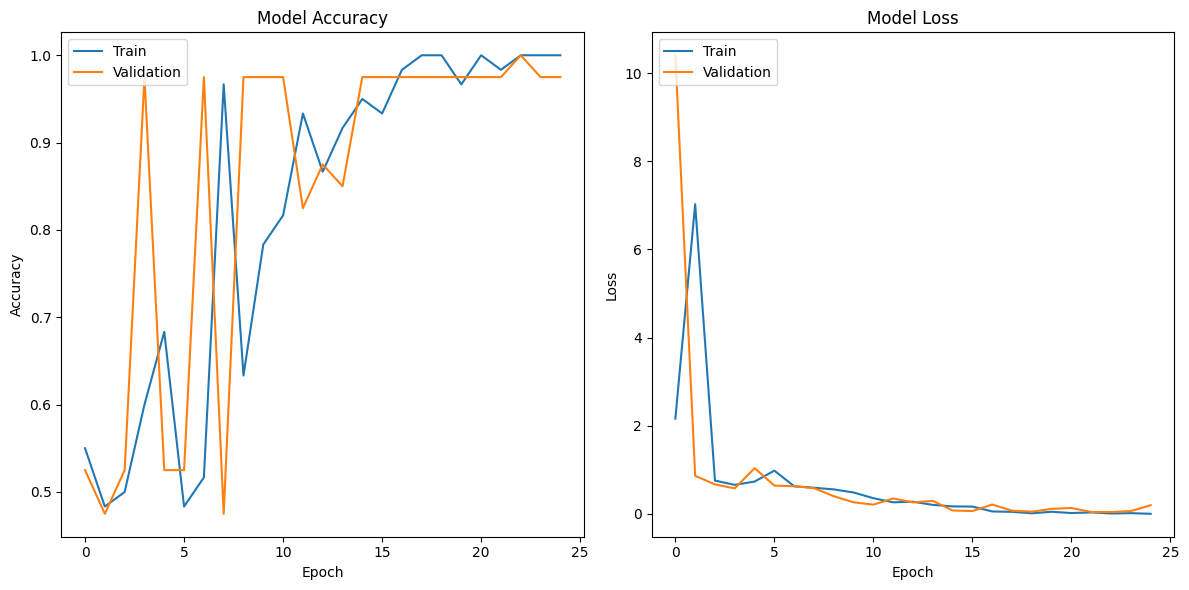

In [29]:
import matplotlib.pyplot as plt
import datetime

# Plot training and validation history
plt.figure(figsize=(12, 6))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])  # Add validation accuracy
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])  # Add validation loss
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()

# Get current date and time
now = datetime.datetime.now()

# Format the date-time string as 'MMDDYYYY-HHMM'
date_time_str = now.strftime("%m%d%Y-%H%M")

# Save the plot with the specified name format
plt.savefig(f"{date_time_str}.png")

plt.show()


2/2 [==============================] - 0s 61ms/step


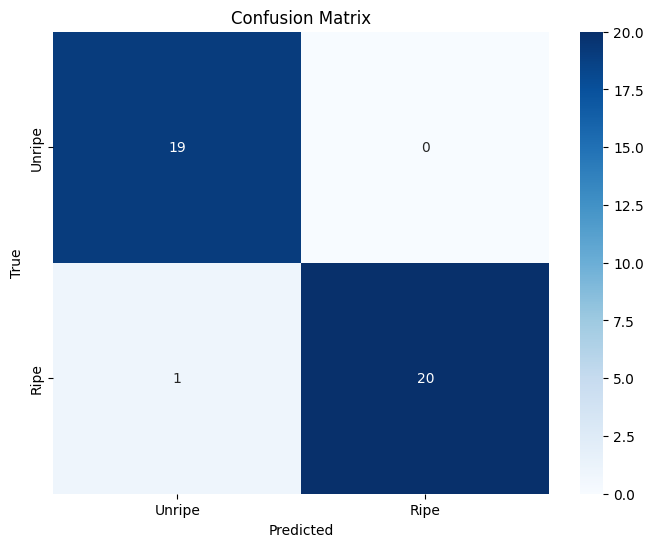

In [30]:
# Generate predictions on the test set
y_pred = model.predict(X_test)
y_pred_classes = (y_pred > 0.5).astype(int)  # Assuming it's a binary classification problem

# Generate the confusion matrix
conf_mat = confusion_matrix(y_test, y_pred_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Unripe', 'Ripe'], yticklabels=['Unripe', 'Ripe'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()